In [2]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
from langgraph.graph import StateGraph
from langchain_openai import ChatOpenAI
from pydantic import BaseModel

In [3]:
def add_value(left, right):
    if right is not None:
        return right
    return left

class State(BaseModel):
    name: Annotated[str, add_value]
    greeting: Annotated[str, add_value]
    timestamp: Annotated[str, add_value]

In [4]:
load_dotenv(override=True)

True

In [5]:
graph_builder = StateGraph(State)

In [6]:
import json

# Node 1: อ่านค่าจาก input.json
def read_input(state: State):
    with open('input.json', 'r', encoding='utf-8') as f:
        data = json.load(f)
    return {"name": data["name"]}

In [7]:
# Node 2: สร้างข้อความทักทาย
def create_greeting(state: State):
    greeting = f"Hello, {state.name}"
    return {"greeting": greeting}

In [8]:
from datetime import datetime

# Node 3: ดึง Timestamp ปัจจุบัน
def get_timestamp(state: State):
    timestamp = datetime.now().isoformat()
    return {"timestamp": timestamp}

In [9]:
# Node 4: บันทึกข้อมูลไปที่ output.json (แบบ Append)
def save_output(state: State):
    output_data = {
        "message": state.greeting,
        "timestamp": state.timestamp,
        "name": state.name
    }
    
    # อ่านข้อมูลเก่า (ถ้ามี)
    try:
        with open('output.json', 'r', encoding='utf-8') as f:
            existing_data = json.load(f)
            # ถ้าไม่ใช่ list ให้แปลงเป็น list
            if not isinstance(existing_data, list):
                existing_data = [existing_data]
    except (FileNotFoundError, json.JSONDecodeError):
        # ถ้าไฟล์ไม่มีหรือ format ผิด ให้สร้างใหม่
        existing_data = []
    
    # เพิ่มข้อมูลใหม่เข้าไป
    existing_data.append(output_data)
    
    # เขียนกลับไปที่ไฟล์
    with open('output.json', 'w', encoding='utf-8') as f:
        json.dump(existing_data, f, ensure_ascii=False, indent=4)
    
    return state

In [10]:
# สร้าง graph โดยเพิ่ม nodes และกำหนด edges
graph_builder.add_node("read_input", read_input)
graph_builder.add_node("create_greeting", create_greeting)
graph_builder.add_node("get_timestamp", get_timestamp)
graph_builder.add_node("save_output", save_output)

# กำหนดลำดับการทำงาน
graph_builder.add_edge(START, "read_input")
graph_builder.add_edge("read_input", "create_greeting")
graph_builder.add_edge("create_greeting", "get_timestamp")
graph_builder.add_edge("get_timestamp", "save_output")
graph_builder.add_edge("save_output", END)

# Compile graph
graph = graph_builder.compile()

In [11]:
# รัน graph
result = graph.invoke({"messages": []})
print(f"Name: {result['name']}")
print(f"Greeting: {result['greeting']}")
print(f"Timestamp: {result['timestamp']}")
print("\nบันทึกข้อมูลไปที่ output.json เรียบร้อยแล้ว")

Name: Wirat
Greeting: Hello, Wirat
Timestamp: 2025-12-10T20:42:28.235444

บันทึกข้อมูลไปที่ output.json เรียบร้อยแล้ว


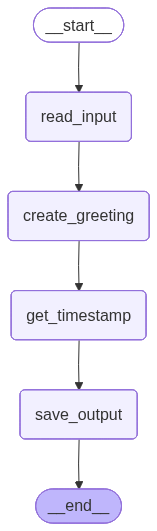

In [12]:
display(Image(graph.get_graph().draw_mermaid_png()))